<a href="https://colab.research.google.com/github/AugustSchreyer/02460_Advanced_ML/blob/main/MBML_der_virker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Init loading

In [1]:
! git clone https://github.com/AugustSchreyer/42186_MBML.git

Cloning into '42186_MBML'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 124 (delta 68), reused 45 (delta 18), pack-reused 0
Receiving objects: 100% (124/124), 7.19 MiB | 13.99 MiB/s, done.
Resolving deltas: 100% (68/68), done.


In [2]:
!pip install pyro-ppl
import torch
import pyro
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoMultivariateNormal
from pyro.optim import ClippedAdam
plt.rcParams['figure.figsize'] = (12, 8)

     |████████████████████████████████| 634kB 8.3MB/s 


### Load data

In [27]:
X_total = pd.read_csv('/content/42186_MBML/data/X_total.csv')
X_tot_bag = pd.read_csv('/content/42186_MBML/data/X_tot_bag.csv')
X_total

,years_since_2015,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,total_volume_Albany_conv,total_volume_Atlanta_conv,total_volume_BaltimoreWashington_conv,total_volume_Boise_conv,total_volume_Boston_conv,total_volume_BuffaloRochester_conv,total_volume_California_conv,total_volume_Charlotte_conv,total_volume_Chicago_conv,total_volume_CincinnatiDayton_conv,total_volume_Columbus_conv,total_volume_DallasFtWorth_conv,total_volume_Denver_conv,total_volume_Detroit_conv,total_volume_GrandRapids_conv,total_volume_GreatLakes_conv,total_volume_HarrisburgScranton_conv,total_volume_HartfordSpringfield_conv,total_volume_Houston_conv,total_volume_Indianapolis_conv,total_volume_Jacksonville_conv,total_volume_LasVegas_conv,total_volume_LosAngeles_conv,total_volume_Louisville_conv,total_volume_MiamiFtLauderdale_conv,total_volume_Midsouth_conv,total_volume_Nashville_conv,...,GrandRapids_conv1,GreatLakes_conv1,HarrisburgScranton_conv1,HartfordSpringfield_conv1,Houston_conv1,Indianapolis_conv1,Jacksonville_conv1,LasVegas_conv1,LosAngeles_conv1,Louisville_conv1,MiamiFtLauderdale_conv1,Midsouth_conv1,Nashville_conv1,NewOrleansMobile_conv1,NewYork_conv1,Northeast_conv1,NorthernNewEngland_conv1,Orlando_conv1,Philadelphia_conv1,PhoenixTucson_conv1,Pittsburgh_conv1,Plains_conv1,Portland_conv1,RaleighGreensboro_conv1,RichmondNorfolk_conv1,Roanoke_conv1,Sacramento_conv1,SanDiego_conv1,SanFrancisco_conv1,Seattle_conv1,SouthCarolina_conv1,SouthCentral_conv1,Southeast_conv1,Spokane_conv1,StLouis_conv1,Syracuse_conv1,Tampa_conv1,TotalUS_conv1,West_conv1,WestTexNewMexico_conv1
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.188583,0.454192,0.643232,0.586858,0.491845,0.577965,0.515208,0.403750,0.434399,0.424441,0.475821,0.576198,0.483585,0.419849,0.633323,0.476802,0.515423,0.635726,0.446308,0.477370,0.385169,0.467282,0.490320,0.595676,0.412181,0.487717,0.413913,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0.190068,0.415062,0.547082,0.420564,0.437867,0.528090,0.537288,0.389003,0.445387,0.373974,0.377154,0.598649,0.482494,0.377229,0.452741,0.432381,0.451725,0.445189,0.445922,0.413236,0.250304,0.403510,0.496085,0.442383,0.261543,0.441885,0.382439,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0.205369,0.450506,0.536886,0.461003,0.401418,0.532161,0.496800,0.371317,0.442539,0.326230,0.349283,0.579016,0.585000,0.331374,0.367311,0.423722,0.461504,0.438636,0.427357,0.445143,0.249649,0.342802,0.511986,0.503920,0.309107,0.440909,0.366187,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0.208304,0.469134,0.565613,0.484458,0.409432,0.567025,0.439635,0.406824,0.413525,0.396559,0.350919,0.534791,0.503543,0.314949,0.352884,0.412796,0.520819,0.461520,0.413105,0.445602,0.275856,0.366800,0.425940,0.510134,0.303704,0.469282,0.359527,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0.327001,0.664833,0.822313,0.832822,0.490128,0.765230,0.805467,0.617787,0.628793,0.558765,0.649833,0.737821,0.716751,0.612977,0.756800,0.687003,0.715585,0.570205,0.537574,0.731430,0.596950,0.544258,0.737072,0.739009,0.574744,0.693861,0.565295,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [14]:
X_ar_total = pd.read_csv('/content/42186_MBML/data/X_ar_total.csv')
X_ar_total.iloc[:,-216:-108]

,Albany_conv0,Atlanta_conv0,BaltimoreWashington_conv0,Boise_conv0,Boston_conv0,BuffaloRochester_conv0,California_conv0,Charlotte_conv0,Chicago_conv0,CincinnatiDayton_conv0,Columbus_conv0,DallasFtWorth_conv0,Denver_conv0,Detroit_conv0,GrandRapids_conv0,GreatLakes_conv0,HarrisburgScranton_conv0,HartfordSpringfield_conv0,Houston_conv0,Indianapolis_conv0,Jacksonville_conv0,LasVegas_conv0,LosAngeles_conv0,Louisville_conv0,MiamiFtLauderdale_conv0,Midsouth_conv0,Nashville_conv0,NewOrleansMobile_conv0,NewYork_conv0,Northeast_conv0,NorthernNewEngland_conv0,Orlando_conv0,Philadelphia_conv0,PhoenixTucson_conv0,Pittsburgh_conv0,Plains_conv0,Portland_conv0,RaleighGreensboro_conv0,RichmondNorfolk_conv0,Roanoke_conv0,...,GrandRapids_conv1,GreatLakes_conv1,HarrisburgScranton_conv1,HartfordSpringfield_conv1,Houston_conv1,Indianapolis_conv1,Jacksonville_conv1,LasVegas_conv1,LosAngeles_conv1,Louisville_conv1,MiamiFtLauderdale_conv1,Midsouth_conv1,Nashville_conv1,NewOrleansMobile_conv1,NewYork_conv1,Northeast_conv1,NorthernNewEngland_conv1,Orlando_conv1,Philadelphia_conv1,PhoenixTucson_conv1,Pittsburgh_conv1,Plains_conv1,Portland_conv1,RaleighGreensboro_conv1,RichmondNorfolk_conv1,Roanoke_conv1,Sacramento_conv1,SanDiego_conv1,SanFrancisco_conv1,Seattle_conv1,SouthCarolina_conv1,SouthCentral_conv1,Southeast_conv1,Spokane_conv1,StLouis_conv1,Syracuse_conv1,Tampa_conv1,TotalUS_conv1,West_conv1,WestTexNewMexico_conv1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1

In [15]:
y_norm = pd.read_csv('/content/42186_MBML/data/y_values.csv')
y_norm

,price_Albany_conv,price_Atlanta_conv,price_BaltimoreWashington_conv,price_Boise_conv,price_Boston_conv,price_BuffaloRochester_conv,price_California_conv,price_Charlotte_conv,price_Chicago_conv,price_CincinnatiDayton_conv,price_Columbus_conv,price_DallasFtWorth_conv,price_Denver_conv,price_Detroit_conv,price_GrandRapids_conv,price_GreatLakes_conv,price_HarrisburgScranton_conv,price_HartfordSpringfield_conv,price_Houston_conv,price_Indianapolis_conv,price_Jacksonville_conv,price_LasVegas_conv,price_LosAngeles_conv,price_Louisville_conv,price_MiamiFtLauderdale_conv,price_Midsouth_conv,price_Nashville_conv,price_NewOrleansMobile_conv,price_NewYork_conv,price_Northeast_conv,price_NorthernNewEngland_conv,price_Orlando_conv,price_Philadelphia_conv,price_PhoenixTucson_conv,price_Pittsburgh_conv,price_Plains_conv,price_Portland_conv,price_RaleighGreensboro_conv,price_RichmondNorfolk_conv,price_Roanoke_conv,...,price_GrandRapids_orga,price_GreatLakes_orga,price_HarrisburgScranton_orga,price_HartfordSpringfield_orga,price_Houston_orga,price_Indianapolis_orga,price_Jacksonville_orga,price_LasVegas_orga,price_LosAngeles_orga,price_Louisville_orga,price_MiamiFtLauderdale_orga,price_Midsouth_orga,price_Nashville_orga,price_NewOrleansMobile_orga,price_NewYork_orga,price_Northeast_orga,price_NorthernNewEngland_orga,price_Orlando_orga,price_Philadelphia_orga,price_PhoenixTucson_orga,price_Pittsburgh_orga,price_Plains_orga,price_Portland_orga,price_RaleighGreensboro_orga,price_RichmondNorfolk_orga,price_Roanoke_orga,price_Sacramento_orga,price_SanDiego_orga,price_SanFrancisco_orga,price_Seattle_orga,price_SouthCarolina_orga,price_SouthCentral_orga,price_Southeast_orga,price_Spokane_orga,price_StLouis_orga,price_Syracuse_orga,price_Tampa_orga,price_TotalUS_orga,price_West_orga,price_WestTexNewMexico_orga
0,1.22,1.00,1.08,1.01,1.02,1.40,0.93,1.19,1.11,0.88,0.89,0.74,0.99,1.01,0.95,1.02,1.05,1.06,0.71,1.02,0.97,0.80,0.85,0.92,0.97,1.10,1.00,0.94,1.09,1.09,1.05,1.00,1.10,0.65,1.52,1.01,0.97,1.20,1.13,1.13,...,1.60,1.54,1.68,2.32,1.22,1.63,1.81,1.50,1.25,1.48,1.82,1.56,1.84,1.41,1.93,1.88,1.83,1.80,1.72,1.12,1.81,1.69,1.28,2.01,1.54,1.39,1.33,1.23,1.18,1.49,1.86,1.35,1.75,1.30,1.80,1.72,1.70,1.46,1.40,1.64
1,1.24,1.11,1.17,1.18,1.10,1.54,0.92,1.26,1.15,0.92,0.97,0.76,1.09,1.08,1.03,1.10,1.26,1.38,0.78,1.25,1.20,0.93,0.85,1.05,1.28,1.17,1.07,0.97,1.34,1.28,1.06,1.29,1.38,0.61,1.54,1.09,1.05,1.24,1.15,1.16,...,1.87,1.69,1.65,2.28,1.26,1.83,1.91,1.54,1.08,1.79,1.85,1.52,1.92,1.44,2.03,1.86,1.88,1.92,1.63,1.36,1.82,1.68,1.22,1.98,1.66,1.47,1.27,1.05,1.12,1.46,2.06,1.39,1.83,1.38,1.84,1.66,1.84,1.42,1.39,1.69
2,1.17,1.11,1.23,1.08,1.23,1.52,1.02,1.25,1.14,0.93,1.02,0.76,0.99,1.10,1.07,1.08,1.24,1.39,0.77,1.14,1.27,1.06,0.89,1.06,1.30,1.19,1.08,1.03,1.37,1.32,1.12,1.33,1.40,0.67,1.47,1.02,1.11,1.22,1.18,1.18,...,1.88,1.73,1.94,2.35,1.20,1.96,1.82,1.63,1.29,1.79,1.87,1.65,1.81,0.98,2.08,1.94,1.88,1.79,1.93,1.36,1.55,1.80,1.24,1.97,1.62,1.48,1.13,1.29,1.27,1.45,1.93,1.27,1.79,1.44,1.92,1.84,1.73,1.42,1.33,1.71
3,1.06,1.10,1.20,1.03,1.17,1.50,1.06,1.18,1.22,0.93,1.08,0.80,1.02,1.19,1.19,1.13,1.17,1.35,0.77,1.06,1.20,1.06,0.96,1.02,1.27,1.15,1.07,0.94,1.36,1.27,1.06,1.28,1.36,0.61,1.32,1.08,1.09,1.16,1.17,1.15,...,2.01,1.63,1.80,2.21,1.24,1.78,1.88,1.66,1.23,1.68,1.84,1.63,1.71,1.47,2.02,1.92,1.90,1.82,1.82,1.54,1.70,1.80,1.35,2.02,1.57,1.47,1.44,1.26,1.34,1.70,2.01,1.37,1.81,1.66,1.93,1.77,1.75,1.53,1.52,1.63
4,0.99,0.96,1.06,0.91,1.22,1.33,0.85,0.98,0.91,0.86,0.87,0.68,0.93,0.92,0.94,0.91,1.06,1.32,0.72,0.92,0.92,0.94,0.74,0.90,0.95,0.99,0.94,0.81,1.36,1.23,1.06,0.95,1.14,0.56,1.25,0.92,0.98,0.99,0.97,1.00,...,1.98,1.53,1.65,1.54,1.15,1.69,1.76,1.60,1.12,1.55,1.73,1.44,1.65,1.48,1.93,1.78,1.89,1.76,1.69,1.18,1.77,1.67,1.20,1.79,1.58,1.50,1.22,1.11,1.06,1.44,1.66,1.28,1.60,1.38,1.93,1.65,1.68,1.36,1.34,1.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [16]:
y_ar = pd.read_csv('/content/42186_MBML/data/y_ar.csv')
y_ar = y_ar.drop(index = 0)
y_ar

,price_Albany_conv_(t-1),price_Atlanta_conv_(t-1),price_BaltimoreWashington_conv_(t-1),price_Boise_conv_(t-1),price_Boston_conv_(t-1),price_BuffaloRochester_conv_(t-1),price_California_conv_(t-1),price_Charlotte_conv_(t-1),price_Chicago_conv_(t-1),price_CincinnatiDayton_conv_(t-1),price_Columbus_conv_(t-1),price_DallasFtWorth_conv_(t-1),price_Denver_conv_(t-1),price_Detroit_conv_(t-1),price_GrandRapids_conv_(t-1),price_GreatLakes_conv_(t-1),price_HarrisburgScranton_conv_(t-1),price_HartfordSpringfield_conv_(t-1),price_Houston_conv_(t-1),price_Indianapolis_conv_(t-1),price_Jacksonville_conv_(t-1),price_LasVegas_conv_(t-1),price_LosAngeles_conv_(t-1),price_Louisville_conv_(t-1),price_MiamiFtLauderdale_conv_(t-1),price_Midsouth_conv_(t-1),price_Nashville_conv_(t-1),price_NewOrleansMobile_conv_(t-1),price_NewYork_conv_(t-1),price_Northeast_conv_(t-1),price_NorthernNewEngland_conv_(t-1),price_Orlando_conv_(t-1),price_Philadelphia_conv_(t-1),price_PhoenixTucson_conv_(t-1),price_Pittsburgh_conv_(t-1),price_Plains_conv_(t-1),price_Portland_conv_(t-1),price_RaleighGreensboro_conv_(t-1),price_RichmondNorfolk_conv_(t-1),price_Roanoke_conv_(t-1),...,price_GrandRapids_orga_(t-1),price_GreatLakes_orga_(t-1),price_HarrisburgScranton_orga_(t-1),price_HartfordSpringfield_orga_(t-1),price_Houston_orga_(t-1),price_Indianapolis_orga_(t-1),price_Jacksonville_orga_(t-1),price_LasVegas_orga_(t-1),price_LosAngeles_orga_(t-1),price_Louisville_orga_(t-1),price_MiamiFtLauderdale_orga_(t-1),price_Midsouth_orga_(t-1),price_Nashville_orga_(t-1),price_NewOrleansMobile_orga_(t-1),price_NewYork_orga_(t-1),price_Northeast_orga_(t-1),price_NorthernNewEngland_orga_(t-1),price_Orlando_orga_(t-1),price_Philadelphia_orga_(t-1),price_PhoenixTucson_orga_(t-1),price_Pittsburgh_orga_(t-1),price_Plains_orga_(t-1),price_Portland_orga_(t-1),price_RaleighGreensboro_orga_(t-1),price_RichmondNorfolk_orga_(t-1),price_Roanoke_orga_(t-1),price_Sacramento_orga_(t-1),price_SanDiego_orga_(t-1),price_SanFrancisco_orga_(t-1),price_Seattle_orga_(t-1),price_SouthCarolina_orga_(t-1),price_SouthCentral_orga_(t-1),price_Southeast_orga_(t-1),price_Spokane_orga_(t-1),price_StLouis_orga_(t-1),price_Syracuse_orga_(t-1),price_Tampa_orga_(t-1),price_TotalUS_orga_(t-1),price_West_orga_(t-1),price_WestTexNewMexico_orga_(t-1)
1,1.22,1.00,1.08,1.01,1.02,1.40,0.93,1.19,1.11,0.88,0.89,0.74,0.99,1.01,0.95,1.02,1.05,1.06,0.71,1.02,0.97,0.80,0.85,0.92,0.97,1.10,1.00,0.94,1.09,1.09,1.05,1.00,1.10,0.65,1.52,1.01,0.97,1.20,1.13,1.13,...,1.60,1.54,1.68,2.32,1.22,1.63,1.81,1.50,1.25,1.48,1.82,1.56,1.84,1.41,1.93,1.88,1.83,1.80,1.72,1.12,1.81,1.69,1.28,2.01,1.54,1.39,1.33,1.23,1.18,1.49,1.86,1.35,1.75,1.30,1.80,1.72,1.70,1.46,1.40,1.64
2,1.24,1.11,1.17,1.18,1.10,1.54,0.92,1.26,1.15,0.92,0.97,0.76,1.09,1.08,1.03,1.10,1.26,1.38,0.78,1.25,1.20,0.93,0.85,1.05,1.28,1.17,1.07,0.97,1.34,1.28,1.06,1.29,1.38,0.61,1.54,1.09,1.05,1.24,1.15,1.16,...,1.87,1.69,1.65,2.28,1.26,1.83,1.91,1.54,1.08,1.79,1.85,1.52,1.92,1.44,2.03,1.86,1.88,1.92,1.63,1.36,1.82,1.68,1.22,1.98,1.66,1.47,1.27,1.05,1.12,1.46,2.06,1.39,1.83,1.38,1.84,1.66,1.84,1.42,1.39,1.69
3,1.17,1.11,1.23,1.08,1.23,1.52,1.02,1.25,1.14,0.93,1.02,0.76,0.99,1.10,1.07,1.08,1.24,1.39,0.77,1.14,1.27,1.06,0.89,1.06,1.30,1.19,1.08,1.03,1.37,1.32,1.12,1.33,1.40,0.67,1.47,1.02,1.11,1.22,1.18,1.18,...,1.88,1.73,1.94,2.35,1.20,1.96,1.82,1.63,1.29,1.79,1.87,1.65,1.81,0.98,2.08,1.94,1.88,1.79,1.93,1.36,1.55,1.80,1.24,1.97,1.62,1.48,1.13,1.29,1.27,1.45,1.93,1.27,1.79,1.44,1.92,1.84,1.73,1.42,1.33,1.71
4,1.06,1.10,1.20,1.03,1.17,1.50,1.06,1.18,1.22,0.93,1.08,0.80,1.02,1.19,1.19,1.13,1.17,1.35,0.77,1.06,1.20,1.06,0.96,1.02,1.27,1.15,1.07,0.94,1.36,1.27,1.06,1.28,1.36,0.61,1.32,1.08,1.09,1.16,1.17,1.15,...,2.01,1.63,1.80,2.21,1.24,1.78,1.88,1.66,1.23,1.68,1.84,1.63,1.71,1.47,2.02,1.92,1.90,1.82,1.82,1.54,1.70,1.80,1.35,2.02,1.57,1.47,1.44,1.26,1.34,1.70,2.01,1.37,1.81,1.66,1.93,1.77,1.75,1.53,1.52,1.63
5,0.99,0.96,1.06,0.91,1.22,1.33,0.85,0.98,0.91,0.86,0.87,0.68,0.93,0.92,0.94,0.

In [28]:
X_tot_bag

,years_since_2015,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,4046_Albany_conv,4225_Albany_conv,4770_Albany_conv,total_bags_Albany_conv,4046_Atlanta_conv,4225_Atlanta_conv,4770_Atlanta_conv,total_bags_Atlanta_conv,4046_BaltimoreWashington_conv,4225_BaltimoreWashington_conv,4770_BaltimoreWashington_conv,total_bags_BaltimoreWashington_conv,4046_Boise_conv,4225_Boise_conv,4770_Boise_conv,total_bags_Boise_conv,4046_Boston_conv,4225_Boston_conv,4770_Boston_conv,total_bags_Boston_conv,4046_BuffaloRochester_conv,4225_BuffaloRochester_conv,4770_BuffaloRochester_conv,total_bags_BuffaloRochester_conv,4046_California_conv,4225_California_conv,4770_California_conv,...,GrandRapids_conv1,GreatLakes_conv1,HarrisburgScranton_conv1,HartfordSpringfield_conv1,Houston_conv1,Indianapolis_conv1,Jacksonville_conv1,LasVegas_conv1,LosAngeles_conv1,Louisville_conv1,MiamiFtLauderdale_conv1,Midsouth_conv1,Nashville_conv1,NewOrleansMobile_conv1,NewYork_conv1,Northeast_conv1,NorthernNewEngland_conv1,Orlando_conv1,Philadelphia_conv1,PhoenixTucson_conv1,Pittsburgh_conv1,Plains_conv1,Portland_conv1,RaleighGreensboro_conv1,RichmondNorfolk_conv1,Roanoke_conv1,Sacramento_conv1,SanDiego_conv1,SanFrancisco_conv1,Seattle_conv1,SouthCarolina_conv1,SouthCentral_conv1,Southeast_conv1,Spokane_conv1,StLouis_conv1,Syracuse_conv1,Tampa_conv1,TotalUS_conv1,West_conv1,WestTexNewMexico_conv1
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.080758,0.144526,0.008482,0.263986,0.658538,0.112482,0.019322,0.109898,0.266002,0.686804,0.478109,0.289091,0.640770,0.683346,0.117893,0.082740,0.084431,0.458230,0.001574,0.398009,0.124376,0.560492,0.016332,0.564651,0.593151,0.553436,0.323947,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0.028724,0.161657,0.021607,0.228892,0.597274,0.089520,0.266992,0.110420,0.253553,0.522753,0.508377,0.318320,0.548027,0.301036,0.142289,0.052528,0.065115,0.370251,0.001488,0.506345,0.062502,0.513113,0.011868,0.528425,0.602734,0.606630,0.244053,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0.026183,0.161146,0.023078,0.323882,0.672881,0.088309,0.120348,0.093994,0.246096,0.488620,0.485055,0.356115,0.724067,0.173610,0.096685,0.041777,0.051450,0.332370,0.001619,0.495048,0.061856,0.622555,0.019871,0.428769,0.580054,0.514558,0.286563,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0.026964,0.169606,0.027900,0.294669,0.711152,0.088387,0.139766,0.085946,0.244859,0.479974,0.472060,0.445201,0.746601,0.206829,0.088287,0.048328,0.055523,0.332735,0.000562,0.528807,0.050283,0.543529,0.011111,0.579136,0.496639,0.446063,0.354711,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0.038779,0.306640,0.030480,0.253301,1.000000,0.149135,0.069369,0.121351,0.459043,0.827299,1.000000,0.337129,0.970547,1.000000,0.124422,0.070889,0.071392,0.431319,0.003333,0.500396,0.080599,0.651848,0.016770,0.858286,1.000000,0.844580,0.417412,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,3,0,0,0,0,1,0,0,0,0,0,0,0,0.296989,0.305139,0.008159,0.927514,0.466158,0.165664,0.371467,0.684755,0.513495,0.595961,0.05697

### Test/train

Make Train/test split

In [36]:
X = X_tot_bag.copy()
y = y_norm.copy()
#X = X_ar_total.copy()
#y = y_ar.copy()
split=0.8  # Fraction of data for train
xtrain=X.iloc[:round(split*len(X)),:]
ytrain=y.iloc[:round(split*len(X)),:]
xtest=X.iloc[round(split*len(X)):,:]
ytest=y.iloc[round(split*len(X)):,:]

In [18]:
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [19]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [20]:
def init_model1(X, obs=None):
    # Separating the data
    #pdb.set_trace()
    X_dates = X[:,:13]
    X_rest = X[:,13:-108]
    X_type = X[:,-108:]
    # Getting device
    device = torch.device('cuda' if torch.cuda.is_available() else "cpu")    
    # intercepts
    
    alpha = pyro.sample("alpha", dist.Normal(1.64*X.new_ones(108),
                                            2*0.22*X.new_ones(108)
                                            ).to_event())                 # Prior for the bias/intercept
    alpha_type = pyro.sample("alpha_type", dist.Normal(0.26,
                                            2*0.05).to_event())                 # Prior for increase in intercept for organic
    #if alpha.is_cuda:
    #    print("alpha is on cuda")
    # beta values (slopes)
    beta_year = pyro.sample("beta_year",dist.Normal(0.12*X.new_ones(1,108),0.05*X.new_ones(1,108)).to_event())
    beta_full = X.new_zeros(X_dates.shape[1]+X_rest.shape[1],108)
    beta_date  = pyro.sample("beta_date", dist.Normal(X.new_zeros(X_dates.shape[1]-1,108),
                                            2*0.1*X.new_ones(X_dates.shape[1]-1,108) ).to_event())    # Priors for the regression coeffcients
    beta_rest = pyro.sample("beta_rest", dist.Normal(-1.22*X.new_ones(1,108),
                                            2*0.38*X.new_ones(1,108) ).to_event())    # Priors for the regression coeffcients
    beta_full[0,:]=beta_year
    beta_full[1:X_dates.shape[1],:]=beta_date
    for i in range(108):
        beta_full[(X_dates.shape[1]+i) :(X_dates.shape[1]+(i+1)) ,i] = beta_rest[:,i]
    #pdb.set_trace()
    #if beta_full.is_cuda:
    #    print("beta is on cuda")
    # Covariance matrix
    
    L_Omega = pyro.sample("L_Omega", dist.LKJCholesky(108,0.1*X.new_ones(1)))
    #if L_Omega.is_cuda:
    #    print("L_Omega is on cuda")

    tau = pyro.sample(name="tau", fn=dist.HalfCauchy(scale=0.1*X.new_ones(108)).to_event() )
    #if tau.is_cuda:
    #    print("tau is on cuda")
    Sigma_lower = torch.matmul(torch.diag(torch.sqrt(tau)), L_Omega)
    #if Sigma_lower.is_cuda:
    #    print("Sigma_lower is on cuda")
    
    with pyro.plate('data',X.size(0)):
        tmp_mean = alpha + X[:,:-108].matmul(beta_full)+X_type*alpha_type
        y_dist = dist.MultivariateNormal(loc = tmp_mean, scale_tril = Sigma_lower)
        y = pyro.sample("y",y_dist, obs=obs)
    
    #if tmp_mean.is_cuda:
    #    print("tmp_mean is on cuda")
    #if y.is_cuda:
    #    print("y is on cuda")   
    
    return y

In [31]:
def init_model2(X, obs=None):
    # Separating the data
    #pdb.set_trace()
    X_dates = X[:,:13]
    X_rest = X[:,13:-108]
    X_type = X[:,-108:]
    # Getting device
    device = torch.device('cuda' if torch.cuda.is_available() else "cpu")    
    # intercepts
    
    alpha = pyro.sample("alpha", dist.Normal(1.59*X.new_ones(108),
                                            2*0.15*X.new_ones(108)
                                            ).to_event())                 # Prior for the bias/intercept
    alpha_type = pyro.sample("alpha_type", dist.Normal(0.27,
                                            2*0.05).to_event())                 # Prior for increase in intercept for organic
    #if alpha.is_cuda:
    #    print("alpha is on cuda")
    # beta values (slopes)
    beta_year = pyro.sample("beta_year",dist.Normal(0.12*X.new_ones(1,108),0.05*X.new_ones(1,108)).to_event())
    beta_full = X.new_zeros(X_dates.shape[1]+X_rest.shape[1],108)
    beta_date  = pyro.sample("beta_date", dist.Normal(X.new_zeros(X_dates.shape[1]-1,108),
                                            2*0.15*X.new_ones(X_dates.shape[1]-1,108) ).to_event())    # Priors for the regression coeffcients
    beta_4046 = pyro.sample("beta_4046", dist.Normal(-0.34*X.new_ones(1,108),
                                            2*0.3*X.new_ones(1,108) ).to_event())    # Priors for the regression coeffcients
    beta_4225 = pyro.sample("beta_4225", dist.Normal(-0.31*X.new_ones(1,108),
                                            2*0.38*X.new_ones(1,108) ).to_event())    # Priors for the regression coeffcients
    beta_4770 = pyro.sample("beta_4770", dist.Normal(-0.08*X.new_ones(1,108),
                                            2*0.18*X.new_ones(1,108) ).to_event())    # Priors for the regression coeffcients
    beta_bags = pyro.sample("beta_bags", dist.Normal(-0.76*X.new_ones(1,108),
                                            2*0.18*X.new_ones(1,108) ).to_event())    # Priors for the regression coeffcients
    
    beta_full[0,:]=beta_year
    beta_full[1:X_dates.shape[1],:]=beta_date
    for i in range(108):
        beta_full[(X_dates.shape[1]+i) :(X_dates.shape[1]+(i+1)) ,i] = beta_4046[:,i]
        beta_full[(X_dates.shape[1]+i+1) :(X_dates.shape[1]+(i+1+1)) ,i] = beta_4225[:,i]
        beta_full[(X_dates.shape[1]+i+2) :(X_dates.shape[1]+(i+2+1)) ,i] = beta_4770[:,i]
        beta_full[(X_dates.shape[1]+i+3) :(X_dates.shape[1]+(i+3+1)) ,i] = beta_bags[:,i]
        
    #pdb.set_trace()
    #if beta_full.is_cuda:
    #    print("beta is on cuda")
    # Covariance matrix
    
    L_Omega = pyro.sample("L_Omega", dist.LKJCholesky(108,0.1*X.new_ones(1)))
    #if L_Omega.is_cuda:
    #    print("L_Omega is on cuda")

    tau = pyro.sample(name="tau", fn=dist.HalfCauchy(scale=0.1*X.new_ones(108)).to_event() )
    #if tau.is_cuda:
    #    print("tau is on cuda")
    Sigma_lower = torch.matmul(torch.diag(torch.sqrt(tau)), L_Omega)
    #if Sigma_lower.is_cuda:
    #    print("Sigma_lower is on cuda")
    
    with pyro.plate('data',X.size(0)):
        tmp_mean = alpha + X[:,:-108].matmul(beta_full)+X_type*alpha_type
        y_dist = dist.MultivariateNormal(loc = tmp_mean, scale_tril = Sigma_lower)
        y = pyro.sample("y",y_dist, obs=obs)
    
    #if tmp_mean.is_cuda:
    #    print("tmp_mean is on cuda")
    #if y.is_cuda:
    #    print("y is on cuda")   
    
    return y

In [44]:
#import pdb

In [48]:
def auto_model1(X, obs=None):
    # Separating the data
    #pdb.set_trace()
    X_dates = X[:,:13]
    X_rest = X[:,13:-216]
    X_type = X[:,-216:-108]
    Yt = X[:,-108:]

    # Getting device
    device = torch.device('cuda' if torch.cuda.is_available() else "cpu")    
    # intercepts
    
    alpha = pyro.sample("alpha", dist.Normal(1.64*X.new_ones(108),
                                            2*0.22*X.new_ones(108)
                                            ).to_event())                 # Prior for the bias/intercept
    alpha_type = pyro.sample("alpha_type", dist.Normal(0.26,
                                            2*0.05).to_event())                 # Prior for increase in intercept for organic
    #if alpha.is_cuda:
    #    print("alpha is on cuda")
    # beta values (slopes)
    beta_year = pyro.sample("beta_year",dist.Normal(0.12*X.new_ones(1,108),0.05*X.new_ones(1,108)).to_event())
    beta_full = X.new_zeros(X_dates.shape[1]+X_rest.shape[1],108)
    beta_date  = pyro.sample("beta_date", dist.Normal(X.new_zeros(X_dates.shape[1]-1,108),
                                            2*0.1*X.new_ones(X_dates.shape[1]-1,108) ).to_event())    # Priors for the regression coeffcients
    beta_rest = pyro.sample("beta_rest", dist.Normal(-1.22*X.new_ones(1,108),
                                            2*0.38*X.new_ones(1,108) ).to_event())    # Priors for the regression coeffcients
    beta_full[0,:]=beta_year
    beta_full[1:X_dates.shape[1],:]=beta_date
    for i in range(108):
        beta_full[(X_dates.shape[1]+i) :(X_dates.shape[1]+(i+1)) ,i] = beta_rest[:,i]
    #pdb.set_trace()
    #if beta_full.is_cuda:
    #    print("beta is on cuda")
    # Covariance matrix
    
    L_Omega = pyro.sample("L_Omega", dist.LKJCholesky(108,0.1*X.new_ones(1)))
    #if L_Omega.is_cuda:
    #    print("L_Omega is on cuda")

    tau = pyro.sample(name="tau", fn=dist.HalfCauchy(scale=0.1*X.new_ones(108)).to_event() )
    #if tau.is_cuda:
    #    print("tau is on cuda")
    Sigma_lower = torch.matmul(torch.diag(torch.sqrt(tau)), L_Omega)
    #if Sigma_lower.is_cuda:
    #    print("Sigma_lower is on cuda")

    phi = pyro.sample(name="phi", fn=dist.Uniform(low = X.new_zeros(1),high = X.new_ones(1)).to_event() )

    #pdb.set_trace()

    with pyro.plate('data',X.size(0)):
        tmp_h = alpha + X[:,:-216].matmul(beta_full)+X_type*alpha_type
        tmp_mean = phi * Yt +(1-phi) * tmp_h
        y_dist = dist.MultivariateNormal(loc = tmp_mean, scale_tril = Sigma_lower)
        y = pyro.sample("y",y_dist, obs=obs)
    
    #if tmp_mean.is_cuda:
    #    print("tmp_mean is on cuda")
    #if y.is_cuda:
    #    print("y is on cuda")   
    
    return y

In [33]:
#X = torch.range(1,100)
#print(X)
#X = X.to(device)
#Y = X*3+6+torch.randn(X.shape).to(device)
#Y = Y.to(device)
#def model3(X,obs=None):
#    alpha = pyro.sample("alpha",dist.Normal(4*X.new_ones(1),3*X.new_ones(1)).to_event())
#    beta = pyro.sample("beta",dist.Normal(2*X.new_ones(1),3*X.new_ones(1)).to_event())
    #print(alpha)
    ##print(beta)
    #print(X)
#    #print(obs)
#    with pyro.plate("data", X.size(0)):
#        y = pyro.sample('y',dist.Normal(alpha+beta*X,1),obs = obs)
#    #print(y)
#    return y
from pyro.infer.autoguide import AutoDiagonalNormal
#guide = AutoDiagonalNormal(model3)


# Setup the inference algorithm

def train(model, guide,X,Y, lr=0.01,n_steps = 1001,clear = False):
    if clear:
        pyro.clear_param_store()
    optimizer = ClippedAdam({"lr": lr})
    svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

    for step in range(n_steps):
        #print(step)
        loss = svi.step(X,Y)
        if step % 200 == 0:
            print('[iter {}]  loss: {:.4f}'.format(step, loss))

In [42]:
# Prepare data for Pyro model


X_train_torch = torch.from_numpy(xtrain.to_numpy()).float().to(device)#[:10,:]
y_train_torch = torch.from_numpy(ytrain.to_numpy()).float().to(device)#[:10,:]
X_test_torch = torch.from_numpy(xtest.to_numpy()).float().to(device)#[:10,:]
y_test_torch = torch.from_numpy(ytest.to_numpy()).float().to(device)#[:10,:]


In [62]:
#import pdb

In [ ]:
pyro.clear_param_store()
guide = AutoDiagonalNormal(init_model2)
#pyro.get_param_store().load("init_param.save")
train(init_model1,guide,X_train_torch,y_train_torch,lr=0.001,n_steps = 25000,clear = True)
pyro.get_param_store().save("init_param2.save")


In [38]:
#model2 = torch.load("init_model.pkl")
#guide = AutoDiagonalNormal(model2)
pyro.get_param_store().load("init_param.save")

for i,k in enumerate(pyro.get_param_store()):
    print(pyro.get_param_store()[k].shape)
    print(pyro.get_param_store()[k])

torch.Size([7507])
Parameter containing:
tensor([ 1.5755,  1.5495,  1.8342,  ..., -2.3373, -2.3611, -2.6536],
       requires_grad=True)
torch.Size([7507])
tensor([0.0970, 0.1000, 0.0969,  ..., 0.0989, 0.1025, 0.1014],
       grad_fn=<AddBackward0>)


In [24]:
for i,k in enumerate(pyro.get_param_store()):
    print(pyro.get_param_store()[k].shape)
    print(pyro.get_param_store()[k])

torch.Size([7507])
Parameter containing:
tensor([ 1.4445,  1.4087,  1.9183,  ..., -3.9131, -4.6514, -3.5791],
       requires_grad=True)
torch.Size([7507])
tensor([0.0065, 0.0022, 0.0023,  ..., 0.0970, 0.0685, 0.0859],
       grad_fn=<AddBackward0>)


In [69]:
from pyro.infer import Predictive

predictive = Predictive(model2, guide=guide, num_samples=1000,
                        return_sites=("alpha","alpha_type", "beta_date","beta_rest","L_Omega" ,"tau","y"))


In [77]:
samples = predictive(X_test_torch)

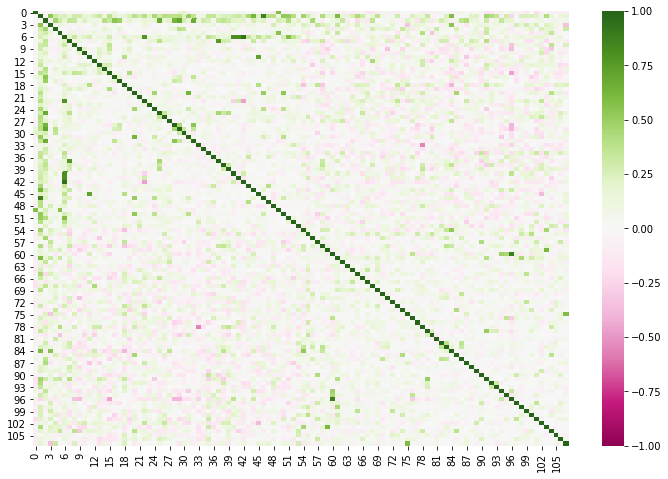

In [71]:
#cm = torch.matmul(torch.diag(torch.sqrt(torch.mean(samples['tau'],dim=0).squeeze(0))), torch.mean(samples['L_Omega'],dim=0).squeeze(0)).numpy()
cm = torch.matmul(torch.diag(torch.sqrt(torch.mean(samples['tau'],dim=0).squeeze(0))), torch.mean(samples['L_Omega'],dim=0).squeeze(0)).cpu().numpy()
cm = cm + cm.T - np.diag(np.diag(cm))
def cov2corr(A):
    """
    covariance matrix to correlation matrix.
    """
    d = np.sqrt(A.diagonal())
    A = ((A.T / d).T) / d
    #A[ np.diag_indices(A.shape[0]) ] = np.ones( A.shape[0] )
    return A
corrm = cov2corr(cm)
sns.heatmap(corrm,vmin=-1,vmax=1,cmap="PiYG")

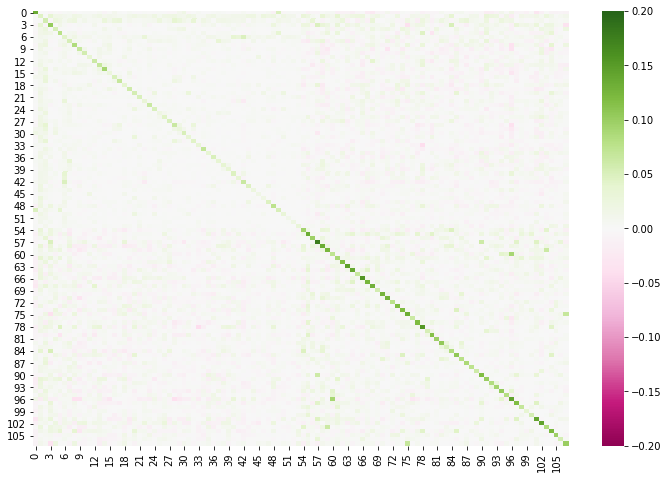

In [74]:
sns.heatmap(cm,vmin=-0.2,vmax=0.2,cmap="PiYG")

In [78]:
mean_y,_ = torch.median(samples['y'],dim=0)
mean_y= torch.mean(samples['y'],dim=0)
mean_y.shape


torch.Size([34, 108])

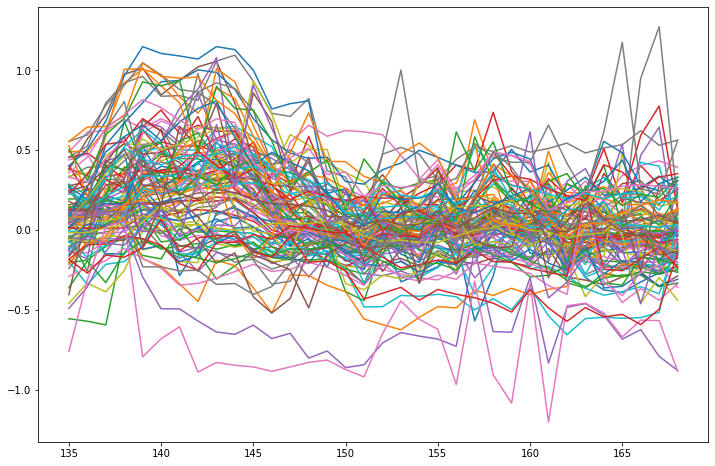

Mean absolute error: 0.2139786338563481 
RMSE 0.08676527041230961


In [80]:
mean_y_np = mean_y.cpu().numpy()
residuals=ytest.iloc[:,:]-mean_y_np[:,:]
plt.plot(residuals)
plt.show()
mae = np.mean(np.abs(residuals.values))
rmse = np.mean(residuals.values**2)
print("Mean absolute error:", mae, "\nRMSE",rmse)